Los objetivos de este notebook son:
- Ilustrar como manejar un `Dataset` de PyTorch que permita obtener batches de datos basados en una serie de tiempo multivariadas, dada una ventana histórica predictiva y una ventana futura a predecir.
- Ilustrar el manejo de los módulos `nn.RNN`, `nn.LSTM` y `nn.GRU` de PyTorch para crear capas de neuronas recurrentes con memorias de largo plazo.
- Aplicar lo aprendido a un proceso de pronóstico de una serie de tiempo multivariada real.

Este notebook está basado en material encontrado en:
- *Time series forecasting*, https://www.tensorflow.org/tutorials/structured_data/time_series
- *Deep Learning with Python*, François Chollet, Manning, 2021.
- *Machine Learning with PyTorch and Scikit-Learn*, Sebastian Raschka, Yuxi Liu & Vahid Mirjalili, Packt, 2022
- *Dive into Deep Learning*, Aston Zhang, Zachary C. Lipton, Mu Li & Alexander J. Smola, https://d2l.ai/, 2022

- *PyTorch*, https://pytorch.org/

# 1. Establecimiento del ambiente de desarrollo y ejecución.

Preparamos el ambiente de desarrollo y ejecución, cargando librerías, verificando el dispositivo disponible (CPU o CUDA), y reseteando el seed.

In [1]:
import numpy as np
import pandas as pd
import os, random, math, time
import requests
from zipfile import ZipFile  
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [108]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 5.3 MB/s eta 0:00:00


In [109]:
import torchmetrics

In [2]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [3]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
sns.set_style('whitegrid')

# 2. Serie de tiempo multivariada

Vamos a utilizar un <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">dataset de clima</a>, con series de tiempo multivariadas, recopilado por el <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

El dataset contiene **14 different variables** como la temperatura del aire, la presión atmosférica, la humedad, etc. Cada serie de tiempo tiene un valor registrado **cada 10 minutos**, empezando en 2003. Por eficiencia, vamos a descargar los datos de 2009 a 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [5]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
zipfile = 'jena_climate_2009_2016.csv.zip'
csvfile = 'jena_climate_2009_2016.csv'

if os.path.exists('/content/'+zipfile):
    print("el archivo ya existe")
else:
    r = requests.get(url, allow_redirects=True)
    open(zipfile, 'wb').write(r.content)

Ahora vamos a descomprimir el archivo, cargarlo en un dataframe y visualizar sus primeros registros.

In [6]:
with ZipFile('/content/'+zipfile, 'r') as zObject:  
    zObject.extractall(path='/content/datos/')

In [7]:
df = pd.read_csv('/content/datos/'+csvfile)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
df.shape

(420551, 15)

Como se puede ver, la primera columna muestra la variable con el timestamp, con cada observación registrada cada 10 minutos. Es decir, 24\*6=144 observaciones al día.

Si quisieramos, por ejemplo, predecir la temperatura dentro de 6 horas en el futuro, a partir de los últimos 5 días, tendríamos una ventana histórica de 5\*144=720 pasos de tiempo, para predecir un valor 6\*5=30 pasos en el futuro.

El total de observaciones del dataset, de 2009 a 2016 es de mas de 420000 registros. Vamos a establecer un punto de corte para separar el dataset de entrenamiento y de validación en 300000 registros de training, que equivalen aproximadamente a 2100 días.

In [9]:
TRAIN_SPLIT = 300000

De las 14 variables que contiene el dataset, vamos a escoger 3 por simplicidad como variables predictivas, con sus respectivas series de tiempo: la temperatura del aire, la presión atmosférica, y la densidad del aire. Establecemos además la variable del timestep como índice.

In [10]:
variables_a_considerar = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [11]:
features = df[variables_a_considerar]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Veamos el comportamiento de estas variables en el tiempo.

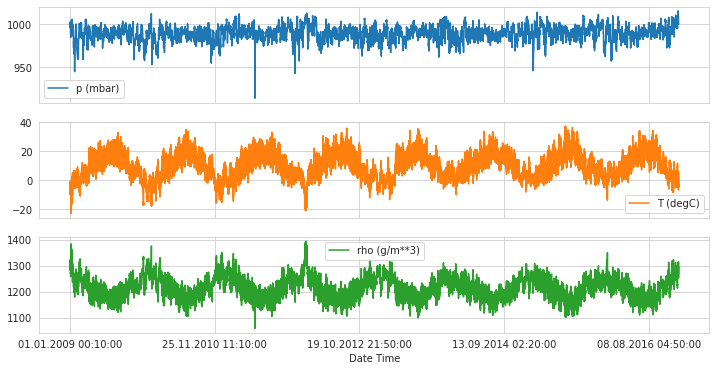

In [12]:
_=features.plot(subplots=True, figsize=(12,6))

Vemos que los valores de las variables tienen diferentes escalas. Para facilitar el proceso y mejorar la estabilidad de los modelos, vamos a normalizar cada serie de tiempo de manera independiente, teniendo en cuenta que los parámetros de tratamiento de los datos **solo deben considerar el dataset de entrenamiento**.

In [13]:
dataset = features.values
promedios = dataset[:TRAIN_SPLIT].mean(axis=0)
desviaciones = dataset[:TRAIN_SPLIT].std(axis=0)

In [14]:
dataset = (dataset-promedios)/desviaciones

# 3. Creación de la subclase de `Dataset` para pronóstico multivariado.

Vamos a crear una subclase de `Dataset` para poder obtener las instancias de entrenamiento y validación de una tarea de forecasting sobre las series de tiempo multivariadas, en la que se quiera pronosticar un solo valor en el futuro. Esta clase recibirá los siguientes parámetros en el momento de su instanciación:

- **dataset**: tensor de rango 2, con el primer eje temporal y el segundo conteniendo las variables.
- **target**: tensor de rango 1 con la variable que se desea predecir
- **start_index**: índice indicando el punto desde el cuál se quiere considerar los valores de la serie
- **end_index**: índice indicando el punto hasta dónde se quiere considerar los valores de la serie
- **history_size**: el tamaño de la ventana de valores predictores históricos (variables independientes) a considerar. Si **step** es mayor a 1, no todos los datos del histórico se tendrán en cuenta. 
- **target_size**: numero de pasos en el futuro después del fin de la ventana a considerar para definir los valores dependientes. En el caso de que **single_step** sea False, solo se considera el valor que esté a **target_size**+1 de distancia del final de la ventana de valores predictores históricos. En el caso de que **single_step** sea True, se considerarán todos los valores desde el final de la ventana histórica hasta **target_size**+1 (no incluido).
- **step**: permite establecer como se escogen los valores secuenciales de la ventna definida por **history_size**, en terminos de los saltos internos dentro de la misma, de un valor escogido al siguiete. Si su valor es 1, se escogen todos los valores de la ventana. Si su valor es 2, se escoge el primer valor de la ventana, el tercero, el quinto, y así sucesivamente. Esta funcionalidad puede ser útil si se considera que los valores de la serie varían poco.
- **single_step**: `False` por defecto. Indica si se va a considerar un único valor futuro a predecir o una ventana de valores a predecir.

In [15]:
class SerieTiempoMultivariadaDataset(Dataset):
    def __init__(self, dataset, target, start_index, end_index,
                 history_size, target_size, step, single_step=False):
        data = []
        labels = []

        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(dataset[indices])

            if single_step:
                labels.append([target[i+target_size]])
            else:
                labels.append(target[i:i+target_size])

        self.data = torch.FloatTensor(np.array(data))
        self.labels = torch.FloatTensor(np.array(labels))
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (idx >= len(self.data)) or (idx < 0):
            raise Exception("Out of bounds: idx=", idx)
        return self.data[idx], self.labels[idx]

Para entender el funcionamiento de esta clase, analicemos un caso en el que definimos:
- que se quiera pronosticar la variable temperatura **target**=dataset[:, 1]
- con un dataset de base que solo considere los primeros 100 datos temporales (**start_index**=0, **end_index**=100)
- una ventana temporal de 1 hora (**history_size** de 6 pasos de tiempo de 10 minutos)
- tomando solo los valores cada 20 minutos ya que no hay muchos cambios (un **step** de a 2 valores)
- para predecir el valor inmediatamente posterior sin salto de tiempo futuro (**future_target** de 0, y **single_step**=True)

In [16]:
past_history = 6 # La última 1 hora
future_target = 0 # Queremos predecir el valor en los siguientes 10 minutos, sin ningún salto
STEP = 2 # Queremos valores cada 20 minutos

dataset_ejemplo = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], 0, 100, 
                                                   past_history, future_target, 
                                                   STEP, single_step=True)

In [17]:
len(dataset_ejemplo)

94

Como tenemos una ventana temporal histórica de 6 valores, el dataset solo podrá tener 100-6=94 instancias.
Analicemos los primeros 20 valores de las series para entender las instancias de los datos y labels que retorna el Dataset:

In [18]:
dataset[:20]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.96154485, -2.04281897,  2.28524007],
       [ 0.95668784, -2.05439744,  2.29600633],
       [ 0.95425934, -2.0312405 ,  2.27031412],
       [ 0.95425934, -2.02660912,  2.26566506],
       [ 0.95304508, -2.00113649,  2.23777066],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.95304508, -1.95134907,  2.18467344],
       [ 0.95304508, -1.98492663,  2.22088721],
       [ 0.95668784, -2.04513467,  2.28646351],
       [ 0.96761611, -2.08334362,  2.33026261],
       [ 0.96761611, -2.09723778,  2.34518855],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.98218713, -2.09144854,  2.34274168],
       [ 0.9906869 , -2.07176515,  2.32365604],
       [ 0.9906869 , -2.07176515,  2.32390073],
       [ 0.99675816, -2.07639653,  2.33026261],
       [ 0.99432965, -2.08913285,  2.34347574],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01011493, -2.10418486,  2.36378482]])

In [19]:
dataset_ejemplo[0]

(tensor([[ 0.9555, -1.9977,  2.2351],
         [ 0.9567, -2.0544,  2.2960],
         [ 0.9543, -2.0266,  2.2657]]), tensor([-1.9513]))

Ahora si establezcamos datasets de training y de test.
Vamos a considerar:
- que se quiera pronosticar la variable temperatura **target**=dataset[:, 1]
- un dataset de base que solo considere los primeros 300000 datos temporales (**start_index**=0, **end_index**=TRAIN_SPLIT)
- una ventana temporal predictiva de 5 días (**history_size** de 6\*24\*5=720 pasos de tiempo de 10 minutos)
- tomando solo los valores cada hora ya que no hay muchos cambios (un **step** de a 6 valores)
- para predecir el valor dentro de 12 horas (**future_target** de 6\*12=72, y **single_step**=True)

In [20]:
past_history = 720 # Los 5 días anteriores
future_target = 72 # Valor dentro de 12 horas
STEP = 6 # Valores cada hora

train_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, 
                                                   STEP, single_step=True)
val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], TRAIN_SPLIT, None, 
                                               past_history, future_target, 
                                               STEP, single_step=True)

Cada instancia del dataset es una dupla con los datos predictivos y los labels a predecir.

Como tenemos 720 pasos de tiempo predictivos, pero valores cada 6 pasos, la ventana histórica queda entonces de 720/6=120 valores, con un único valor de ground truth a predecir.

In [21]:
ventana_historica = past_history / STEP

In [22]:
train_data[0][0].shape

torch.Size([120, 3])

In [23]:
train_data[0][1].shape

torch.Size([1])

Ya que tenemos el dataset creado, vamos ahora a crear un `DataLoader` para poder obtener batches de entrenamiento y validación de cualquier modelo que vayamos a implementar.
El `DataLoader` de entrenamiento lo barajamos con `shuffle=True`, para no introducir sesgos de orden de presentación de instancias de aprendizale; el de test no requiere de ese tratamiento.

In [24]:
BATCH_SIZE=256

In [25]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# 4. Modelo recurrente simple con `RNN`

Vamos ahora a ilustrar como crear un modelo de forecasting multivariado con capas recurrentes `nn.RNN` simples, en donde se tomarán las series de tiempo de 3 variables, para predecir el valor de una de ellas en el futuro.

Vamos a crear un modelo de forecasting multivariado con capas recurrentes seimples `nn.RNN` y una capa densa `nn.Linear` de salida (sin función de activación).
El modelo recibirá los siguientes hiper parámetros:
- `input_dim`: número de *features* predictivos.
- `hidden_dim`: número de neuronas escondidas en las capas del submódulo recurrente.
- `layer_dim`: número de capas en el submódulo recurrente.
- `output_dim`: número de neuronas de salida de la capa densa final.

La capa `nn.Linear` final deberá recibir sólo los estados escondidos de salida  del último paso de tiempo, por lo que se deberán desechar los anteriores.


In [26]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu').to(DEVICE)

        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim).to(DEVICE)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, hn = self.rnn(x, h0.detach())

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa 
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :]) 
        return out

Vamos a instanciar el modelo para tratar los datos de forecasting de la función del seno del dataset previamente creados:
- Se tienen 3 features de entrada
- Creamos 2 capas recurrentes con 5 neuronas cada una
- Solo vamos a tener un único output con el valor de la serie a predecir.

In [27]:
num_features = 3
num_hidden_neurons_per_layer = 5
num_layers = 2
num_outputs = 1
modelo_forecasting_RNN = RNNModel(
    input_dim=num_features, 
    hidden_dim=num_hidden_neurons_per_layer, 
    layer_dim=num_layers, 
    output_dim=num_outputs)

Recordemos que el modelo espera la primera capa de entrada es una `RNN`, que espera un tensor de entrada con sus ejes organizados así: **(batch_size, timesteps, input_features)**, que concuerda con lo que produce el data loader.

In [28]:
train_features, train_labels = next(iter(train_dataloader))

In [29]:
train_features.shape

torch.Size([256, 120, 3])

Pasemos este batch por inferencia del modelo.

In [30]:
salida = modelo_forecasting_RNN(train_features.to(DEVICE))
print("salida:\n ", salida.shape, "\n ", salida[:10])

salida:
  torch.Size([256, 1]) 
  tensor([[0.5925],
        [0.3791],
        [0.5567],
        [0.3891],
        [0.4104],
        [0.5446],
        [0.4251],
        [0.4227],
        [0.4245],
        [0.5002]], device='cuda:0', grad_fn=<SliceBackward0>)


Vemos que por cada secuencia del batch, el modelo produce un valor de salida.

Vamos a definir varias funciones:
- una función con el proceso de entrenamiento del modelo
- una función para plotear la evolución del loss a medida que avanzan las épocas de entrenamiento
- una función que reciba un dataset de series de tiempo y retorne los 
- una función para plotear los valores reales vs los predichos por el modelo.

In [31]:
def train_model_forecasting(modelo, train_dataset, val_dataset, batch_size=32, learning_rate = 1e-3, epocas=30, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento de un modelo de forecasting.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_dataset:
        instancia de Dataset con los datos de validación
    :batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses del val set después de cada época
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.MSELoss() # se usa una función de pérdida de regresión
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    val_losses = [0] * epocas

    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normaliza el loss del training set
        train_losses[epoca] /= len(train_loader.dataset)
        
        # se desactiva la diferenciación automática para la inferencia sobre el val set
        modelo.eval()
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                batch_features = batch_features.to(DEVICE)
                batch_labels = batch_labels.to(DEVICE)
                # Generar las predicciones
                batch_preds = modelo(batch_features)
                # Comparar con las realidades a partir del loss function
                loss = loss_fn(batch_preds, batch_labels)
                # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                val_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normalizan el loss del val set
        val_losses[epoca] /= len(val_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}",
                    f"-- epoch time: {segundos:.2f}")
    return modelo, train_losses, val_losses

In [32]:
def plot_losses(train_losses, val_losses=None):
    plt.figure(figsize=(6, 3), dpi=120)

    plt.plot(train_losses)
    if val_losses is not None:
        plt.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    _=plt.show()

In [33]:
def pronostico(modelo, forecast_dataset, batch_size):
    modelo.eval()
    preds_loader = DataLoader(forecast_dataset, batch_size=batch_size, shuffle=False)
    preds = torch.empty((0)).to(DEVICE)
    with torch.no_grad():    
        for batch_idx, (batch_features, batch_labels) in enumerate(preds_loader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).unsqueeze(-1).float()
            batch_preds = torch.squeeze(modelo(batch_features), -1)
            preds = torch.concatenate((preds, batch_preds), axis=0)
            # print(f"batch: {batch_idx}\npreds:{len(preds)}")
    return preds

In [34]:
def plot_reals_vs_preds(reals, preds):
    num_puntos = len(reals)
    plt.figure(figsize=(12, 5))

    plt.scatter(np.arange(num_puntos), reals, color = 'blue', marker = ".") 
    plt.scatter(np.arange(num_puntos), preds, color = 'green', marker = ".") 
    plt.title("Valores reales vs. predichos") 
    plt.xlabel("X") 
    plt.ylabel("Y") 
    plt.legend(['reals', 'preds'], loc='upper left')

    _=plt.show()

In [35]:
def proceso_completo(past_history = 720, future_target = 72, step=6, num_capas=1, num_hidden=5, showPlots=False):
    reset_seed()
    train_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], 0, TRAIN_SPLIT, 
                                                    past_history, future_target, 
                                                    step, single_step=True)
    val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], TRAIN_SPLIT, None, 
                                                past_history, future_target, 
                                                step, single_step=True)

    modelo_forecasting_RNN = RNNModel(input_dim=num_features, hidden_dim=num_hidden, layer_dim=num_capas, output_dim=num_outputs)
    (modelo_forecasting_RNN, train_losses, val_losses) = \
        train_model_forecasting(modelo_forecasting_RNN, train_data, val_data, batch_size=BATCH_SIZE, learning_rate=1e-3, epocas=5)

    preds = pronostico(modelo_forecasting_RNN, val_data, BATCH_SIZE).cpu().numpy()
    reals = torch.squeeze(val_data.labels)

    print(f"last val loss: {val_losses[-1]}")

    if showPlots:
        plot_losses(train_losses, val_losses)
        plot_reals_vs_preds(reals, preds)
    
    return past_history, train_losses[-1], val_losses[-1]

last val loss: 0.11473902153489422


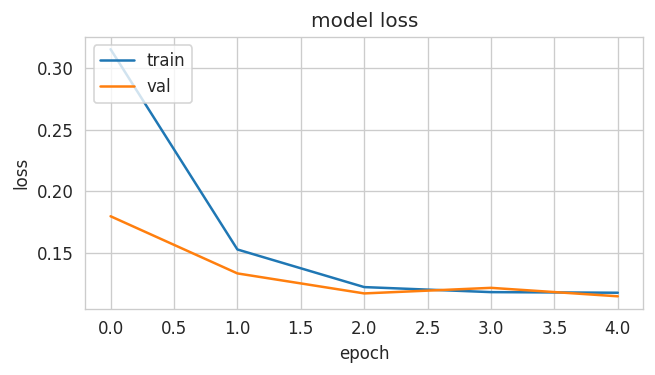

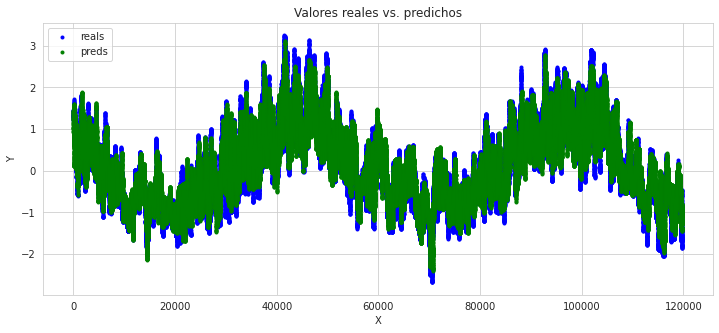

(720, 0.11764554145803939, 0.11473902153489422)

In [36]:
proceso_completo(past_history=720, future_target=72, step=6, num_capas=1, num_hidden=5, showPlots=True)

last val loss: 0.1183198316453253


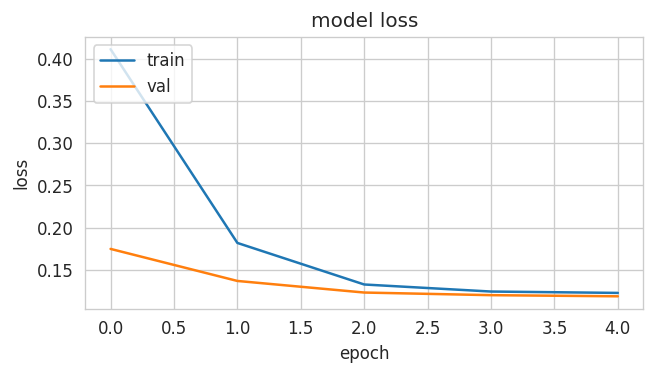

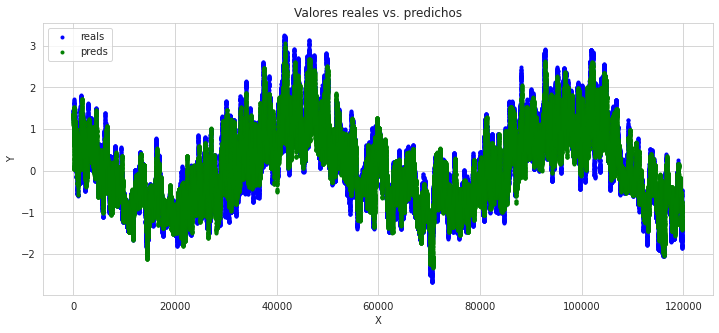

(720, 0.12235906617554138, 0.1183198316453253)

In [95]:
proceso_completo(past_history=720, future_target=72, step=6, num_capas=2, num_hidden=5, showPlots=True)

last val loss: 0.10486017305556898


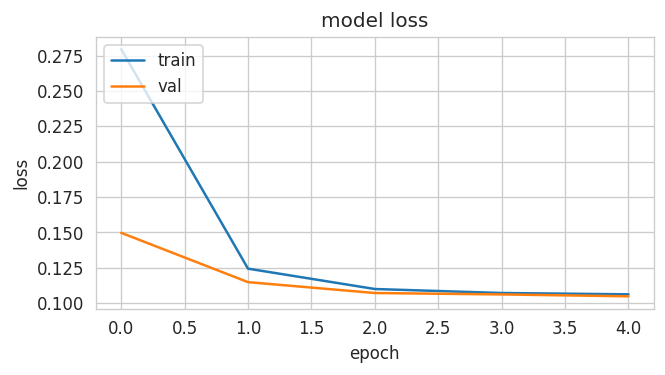

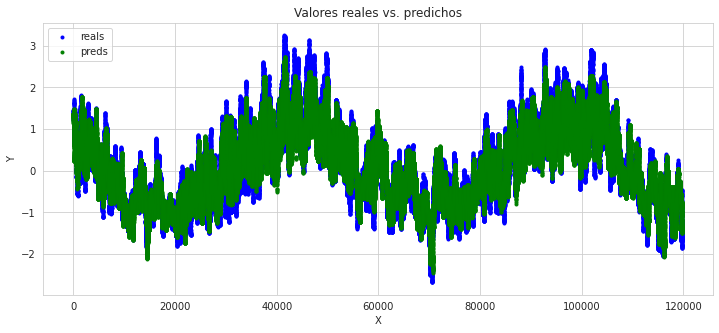

(720, 0.10625558201601021, 0.10486017305556898)

In [96]:
proceso_completo(past_history=720, future_target=72, step=6, num_capas=1, num_hidden=10, showPlots=True)

last val loss: 0.1115507781435595


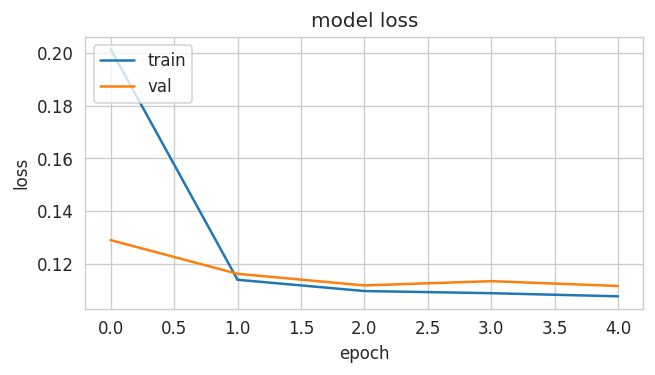

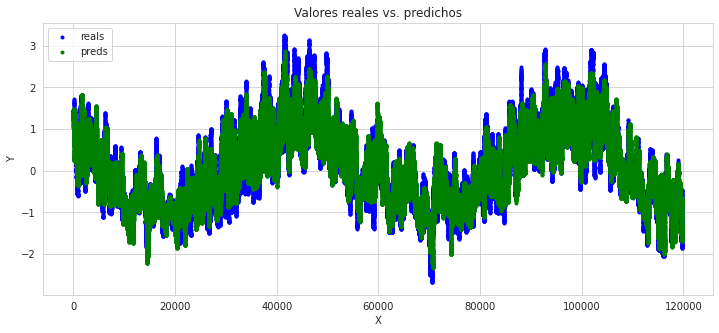

(720, 0.10763163908905793, 0.1115507781435595)

In [97]:
proceso_completo(past_history=720, future_target=72, step=6, num_capas=2, num_hidden=10, showPlots=True)

last val loss: 0.10890253665331588


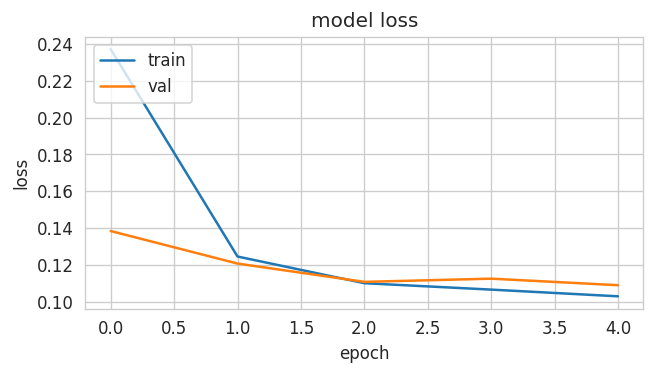

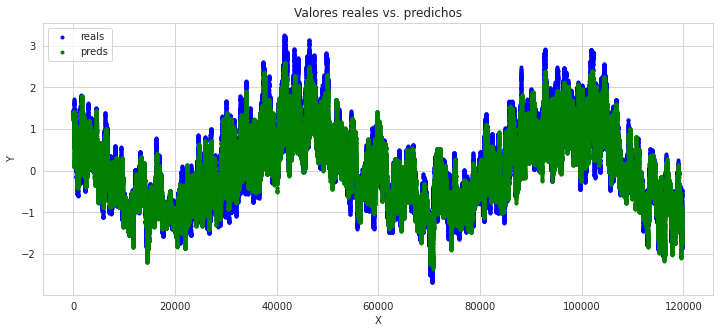

(720, 0.1028610160479218, 0.10890253665331588)

In [98]:
proceso_completo(past_history=720, future_target=72, step=6, num_capas=1, num_hidden=15, showPlots=True)

last val loss: 0.10578434841418073


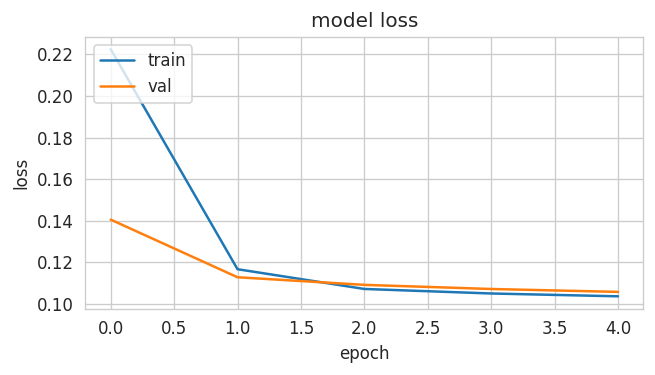

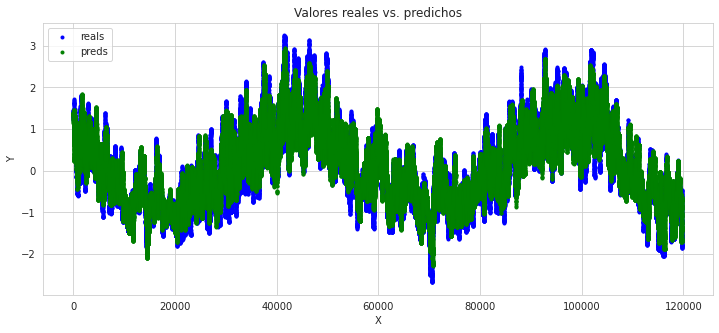

(720, 0.10366103801218082, 0.10578434841418073)

In [99]:
proceso_completo(past_history=720, future_target=72, step=6, num_capas=1, num_hidden=20, showPlots=True)

# 5. Módulos LSTM y GRU

Vamos ahora a intentar con modelos con memoria de largo alcance.
Definimos clases para modelos con submódulos recurrentes con capas `nn.LSTM` y `nn.GRU`, siguiendo el mismo esquema que el modelo anterior basado en `nn.RNN`.

La interacción con ambos submódulos es muy parecida a la del `RNN`. Veamos inicialmente como funciona cada submódulo.

Un submódulo `nn.LSTM` permite crear una o varias capas recurrentes de tipo **LSTM**, para lo cual se debe especificar:
- `input_size`: el número de variables de entrada de la capa inicial. A no confundir con el tamaño de la secuencia, hablamos aquí de los *features*, por ejemplo, la temperatura, la presión atmosférica, la cantidad de precipitación.
- `hidden_size`: el número de neuronas recurrentes de cada capa apilada.
- `num_layers`: el número de capas recurrentes a apilar. Si tenemos mas de una capa, las capas subsiguientes reciben como entrada los outputs de las capas anteriores.
- `batch_first`: Si es `True`, los tensores de entrada y de salida presentan los ejes en este orden **(batch_size, timesteps, input_features)** en vez de **(timesteps, batch_size, input_features)**. Esto no aplica para los estados intermedios, solo para entradas y salidas. Por defecto es `False`.
- `dropout`: si diferente de 0, probabilidad utilizada por capas de `Dropout` intermedias entre las capas recurrentes. Por defecto es 0.
- `bidirectional`: controla si las capas recurrentes son bidireccionales o no. Por defecto es `False`.

El modulo `LSTM` espera un **tensor de entrada** cuyos ejes se organizan en el orden **(timesteps, batch_size, input_features)** si `batch_first=False`, o **(batch_size, timesteps, input_features)** si `batch_first=True`.
Adicionalmente también habríamos podido enviar en el llamado un tensor con los estados iniciales $h_0$ y los cell states $c_0$ a considerar para todas las capas del módulo `RNN`, pero al no enviarlo, estima un tensor con ceros por defecto.

El llamado al módulo va a retornar tres tensores:
- un tensor de **outputs** con todos los estados de salida de las neuronas de la última capa recurrente (en este ejemplo una única capa), para todos los pasos de tiempo de la secuencia, cuyos ejes se organizan en  **(batch_size, timesteps, output_features)**, si `batch_first=True`.
- un tensor con los **hidden states** de salida del último paso para las neuronas de la última capa recurrente, cuyos ejes se organizan en  **(num_layers (\*2 si bidireccional), batch_size, output_features)**. Estos están considerados en el tensor de **outputs**.
- un tensor con los **cell states** de salida del último paso para las neuronas de la última capa recurrente, cuyos ejes se organizan en  **(num_layers (\*2 si bidireccional), batch_size, output_features)**. Estos están considerados en el tensor de **outputs**.

Vamos a crear un tensor de entrada para analizar su proceso a traves de un módulo `LSTM`. En este caso, vamos a tener una instancia con sequencias de 3 pasos de tiempo para 5 features. Cada instancia tendra un tensor organizado así: (timesteps=3, input_features=5).

In [44]:
x_seq = torch.tensor([[1.0]*5, [2.0]*5, [3.0]*5]).float()
print(x_seq.shape)
print(x_seq)

torch.Size([3, 5])
tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])


In [55]:
reset_seed()
lstm = nn.LSTM(input_size=5, hidden_size=3, num_layers=1, batch_first=True)

In [56]:
lstm(torch.reshape(x_seq, (1, 3, 5)))

(tensor([[[-0.0170,  0.0160,  0.2735],
          [ 0.0645,  0.0477,  0.4026],
          [ 0.2172,  0.0411,  0.4880]]], grad_fn=<TransposeBackward0>),
 (tensor([[[0.2172, 0.0411, 0.4880]]], grad_fn=<StackBackward0>),
  tensor([[[0.6542, 0.5372, 1.0005]]], grad_fn=<StackBackward0>)))

In [57]:
output, (hn, cn) = lstm(torch.reshape(x_seq, (1, 3, 5)))
print("output:", output.shape, "\n  ",output)
print("hn:", hn.shape, "\n  ", hn)
print("cn:", cn.shape, "\n  ", hn)

output: torch.Size([1, 3, 3]) 
   tensor([[[-0.0170,  0.0160,  0.2735],
         [ 0.0645,  0.0477,  0.4026],
         [ 0.2172,  0.0411,  0.4880]]], grad_fn=<TransposeBackward0>)
hn: torch.Size([1, 1, 3]) 
   tensor([[[0.2172, 0.0411, 0.4880]]], grad_fn=<StackBackward0>)
cn: torch.Size([1, 1, 3]) 
   tensor([[[0.2172, 0.0411, 0.4880]]], grad_fn=<StackBackward0>)


En cuanto a los módulos `nn.GRU`, comparte el mismo funcionamiento que el `nn.LSTM`, salvo que solo produce un único tensor de estados escondidos. 

In [58]:
reset_seed()
gru = nn.GRU(input_size=5, hidden_size=3, num_layers=1, batch_first=True)

In [59]:
gru(torch.reshape(x_seq, (1, 3, 5)))

(tensor([[[0.1028, 0.6162, 0.4849],
          [0.2333, 0.8948, 0.9317],
          [0.3389, 0.9790, 0.9968]]], grad_fn=<TransposeBackward1>),
 tensor([[[0.3389, 0.9790, 0.9968]]], grad_fn=<StackBackward0>))

In [60]:
output, hn = gru(torch.reshape(x_seq, (1, 3, 5)))
print("output:", output.shape, "\n  ",output)
print("hn:", hn.shape, "\n  ", hn)


output: torch.Size([1, 3, 3]) 
   tensor([[[0.1028, 0.6162, 0.4849],
         [0.2333, 0.8948, 0.9317],
         [0.3389, 0.9790, 0.9968]]], grad_fn=<TransposeBackward1>)
hn: torch.Size([1, 1, 3]) 
   tensor([[[0.3389, 0.9790, 0.9968]]], grad_fn=<StackBackward0>)


# 6. Modelos de forecasting con módulos `LSTM` y `GRU`

Creemos ahora un modelo que incluya un submódulo inicial `LSTM`.

In [73]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True).to(DEVICE)
        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim).to(DEVICE)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa 
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :]) 
        
        return out

In [62]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRUModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True).to(DEVICE)

        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim).to(DEVICE)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, hn = self.gru(x, h0.detach())

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa 
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :]) 
        return out

In [112]:
def proceso_completo(modelo='lstm', past_history = 720, future_target = 72, step=6, num_capas=1, num_hidden=5, showPlots=False):
    reset_seed()
    train_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], 0, TRAIN_SPLIT, 
                                                    past_history, future_target, 
                                                    step, single_step=True)
    val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], TRAIN_SPLIT, None, 
                                                past_history, future_target, 
                                                step, single_step=True)

    if modelo=='rnn':
        modelo_forecasting = \
            RNNModel(input_dim=num_features, hidden_dim=num_hidden,\
                     layer_dim=num_capas, output_dim=num_outputs)
        (modelo_forecasting, train_losses, val_losses) = \
            train_model_forecasting(modelo_forecasting, train_data, val_data,\
                                    batch_size=BATCH_SIZE, learning_rate=1e-3,\
                                    epocas=5)
    elif modelo=='lstm':
        modelo_forecasting = \
            LSTMModel(input_dim=num_features, hidden_dim=num_hidden,\
                      layer_dim=num_capas, output_dim=num_outputs)
        (modelo_forecasting, train_losses, val_losses) = \
            train_model_forecasting(modelo_forecasting, train_data, val_data, \
                                    batch_size=BATCH_SIZE, learning_rate=1e-3,\
                                    epocas=5)
    elif modelo=='gru':
        modelo_forecasting = \
            GRUModel(input_dim=num_features, hidden_dim=num_hidden, \
                     layer_dim=num_capas, output_dim=num_outputs)
        (modelo_forecasting, train_losses, val_losses) = \
            train_model_forecasting(modelo_forecasting, train_data, val_data,\
                                    batch_size=BATCH_SIZE, learning_rate=1e-3,\
                                    epocas=5)
    else:
        raise Exception("Modelo invalido: ", modelo)

    preds = pronostico(modelo_forecasting, val_data, BATCH_SIZE).cpu().numpy()
    reals = torch.squeeze(val_data.labels)

    print(f"last val loss: {val_losses[-1]}")

    if showPlots:
        plot_losses(train_losses, val_losses)
        plot_reals_vs_preds(reals, preds)

    return modelo_forecasting, past_history, train_losses[-1], val_losses[-1]

Vamos a buscar la mejor configuración en cuanto al número de neuronas de una única capa recurrente con RNN, LSTM y GRU

In [103]:
resultados_rnn = []
for neuronas in np.arange(10, 61, 10):
    modelo_start_time = time.time()
    print(f"Proceso para {neuronas} neuronas escondidas")
    resultados_rnn.append(proceso_completo( \
        modelo='rnn', past_history=720, future_target=72, step=6,
        num_capas=1, num_hidden=neuronas, showPlots=False)[1:])    
    modelo_end_time = time.time()
    segundos = modelo_end_time - modelo_start_time
    print(f"  tomó {segundos:.2f} segundos")

Proceso para 10 neuronas escondidas
last val loss: 0.10486017305556898
  tomó 56.66 segundos
Proceso para 20 neuronas escondidas
last val loss: 0.10578434841418073
  tomó 56.29 segundos
Proceso para 30 neuronas escondidas
last val loss: 0.10344364949345344
  tomó 58.08 segundos
Proceso para 40 neuronas escondidas
last val loss: 0.11037786665211317
  tomó 57.30 segundos
Proceso para 50 neuronas escondidas
last val loss: 0.10145302194967006
  tomó 57.61 segundos
Proceso para 60 neuronas escondidas
last val loss: 0.10265009452317397
  tomó 58.11 segundos


In [104]:
resultados_lstm = []
for neuronas in np.arange(10, 61, 10):
    modelo_start_time = time.time()
    print(f"Proceso para {neuronas} neuronas escondidas")
    resultados_lstm.append(proceso_completo( \
        modelo='lstm', past_history=720, future_target=72, step=6,
        num_capas=1, num_hidden=neuronas, showPlots=False)[1:])    
    modelo_end_time = time.time()
    segundos = modelo_end_time - modelo_start_time
    print(f"  tomó {segundos:.2f} segundos")

Proceso para 10 neuronas escondidas
last val loss: 0.10213762242665067
  tomó 57.59 segundos
Proceso para 20 neuronas escondidas
last val loss: 0.09960167730405245
  tomó 59.35 segundos
Proceso para 30 neuronas escondidas
last val loss: 0.09729218345380664
  tomó 58.77 segundos
Proceso para 40 neuronas escondidas
last val loss: 0.10131155108578879
  tomó 61.08 segundos
Proceso para 50 neuronas escondidas
last val loss: 0.09835280797810277
  tomó 63.04 segundos
Proceso para 60 neuronas escondidas
last val loss: 0.10144073203739726
  tomó 63.43 segundos


In [105]:
resultados_gru = []
for neuronas in np.arange(10, 61, 10):
    modelo_start_time = time.time()
    print(f"Proceso para {neuronas} neuronas escondidas")
    resultados_gru.append(proceso_completo( \
        modelo='gru', past_history=720, future_target=72, step=6,
        num_capas=1, num_hidden=neuronas, showPlots=False)[1:])    
    modelo_end_time = time.time()
    segundos = modelo_end_time - modelo_start_time
    print(f"  tomó {segundos:.2f} segundos")

Proceso para 10 neuronas escondidas
last val loss: 0.1013865730877332
  tomó 59.22 segundos
Proceso para 20 neuronas escondidas
last val loss: 0.09763367002942312
  tomó 59.71 segundos
Proceso para 30 neuronas escondidas
last val loss: 0.09714712648103767
  tomó 57.99 segundos
Proceso para 40 neuronas escondidas
last val loss: 0.09756641445476631
  tomó 61.67 segundos
Proceso para 50 neuronas escondidas
last val loss: 0.09819339703369426
  tomó 64.10 segundos
Proceso para 60 neuronas escondidas
last val loss: 0.09930466233978245
  tomó 65.55 segundos


Vemos que el mejor modelo se obtuvo con una red con capas `GRU`, con una capa con 30 celdas escondidas recurrentes.
Veamos los gráficos de desempeño.

last val loss: 0.09714712648103767


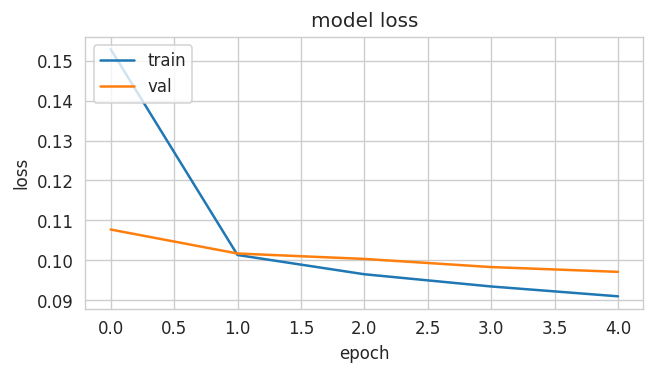

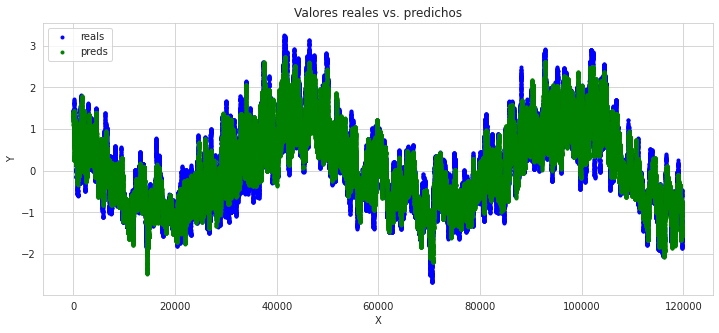

In [113]:
mejor_modelo, _, _, _ = proceso_completo( \
        modelo='gru', past_history=720, future_target=72, step=6,
        num_capas=1, num_hidden=30, showPlots=True)

Finalmente, para validar que el modelo tenga sentido, vamos a comparar el mejor modelo obtenido con un modelo ingenuo que toma el último valor como indicativo del valor real.

In [129]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [130]:
val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 1], TRAIN_SPLIT, None, 
                                            past_history, future_target, 
                                            6, single_step=True)

reals = torch.squeeze(val_data.labels)
preds = pronostico(mejor_modelo, val_data, BATCH_SIZE).cpu().numpy()

naive_reals=val_data.labels[future_target:]
naive_preds=val_data.labels[:-future_target]

print(f"MAPE modelo:   {mean_absolute_percentage_error(reals, preds)}")
print(f"MAPE baseline: {mean_absolute_percentage_error(naive_reals, naive_preds)}")

print(f"RMSE modelo:   {math.sqrt(mean_squared_error(reals, preds))}")
print(f"RMSE baseline: {math.sqrt(mean_squared_error(naive_reals, naive_preds))}")

print(f"R2 modelo:   {r2_score(reals, preds)}")
print(f"R2 baseline: {r2_score(naive_reals, naive_preds)}")


MAPE modelo:   1.610954999923706
MAPE baseline: 3.2071244716644287
RMSE modelo:   0.3116843426867484
RMSE baseline: 0.6543972564672399
R2 modelo:   0.8822903680061261
R2 baseline: 0.4810518132874967
